In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import confusion_matrix,f1_score,recall_score,precision_score,classification_report
import seaborn as sns
from tensorflow.keras import layers, models

In [53]:
# load dataset
train = pd.read_csv('mnist_train.csv')
test = pd.read_csv('mnist_test.csv')

train

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
x_train=train.iloc[:,1:].values
x_test=test.iloc[:,1:].values
y_train=train['label'].values
y_test=test['label'].values
x_train[6,:].shape

(784,)

In [55]:
# Preprocess the data
x_train = x_train.reshape((-1, 28, 28, 1)) / 255.0  # Reshape and normalize training images
x_test = x_test.reshape((-1, 28, 28, 1)) / 255.0    # Reshape and normalize test images
y_train = keras.utils.to_categorical(y_train, num_classes=10)  # Convert training labels to one-hot encoded vectors
y_test = keras.utils.to_categorical(y_test, num_classes=10)    # Convert test labels to one-hot encoded vectors

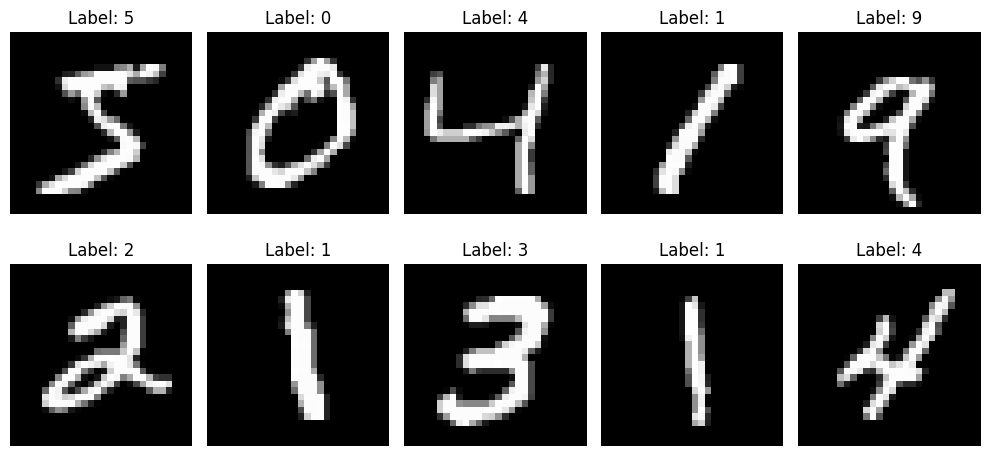

In [56]:
# Visualize sample images from the dataset
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()
for i in range(10):
    axes[i].imshow(x_train[i].reshape(28, 28), cmap='gray')
    axes[i].set_title(f"Label: {np.argmax(y_train[i])}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [57]:
def vgg16_model(input_shape):
    model = models.Sequential()
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(layers.Conv2D(2, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    return model

In [58]:
def inception_module(x, filters):
    conv1x1_1 = layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = layers.Conv2D(filters[1], (3, 3), padding='same', activation='relu')(x)
    conv5x5 = layers.Conv2D(filters[2], (5, 5), padding='same', activation='relu')(x)
    
    maxpool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    conv1x1_2 = layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu')(maxpool)
    
    inception_block = layers.concatenate([conv1x1_1, conv3x3, conv5x5, conv1x1_2], axis=-1)
    
    return inception_block

In [59]:
input_shape = (28, 28, 1)  # ,mnist images are 28x28 pixels with one channel
num_classes = 10

input_layer = layers.Input(shape=input_shape)
vgg16_output = vgg16_model(input_shape)(input_layer)

inception_output = inception_module(vgg16_output, [64, 64, 32, 32])

# Flatten and add fully connected layers for classification
x = layers.Flatten()(inception_output)
x = layers.Dense(512, activation='relu')(x)
output_layer = layers.Dense(num_classes, activation='softmax')(x)

# Create the combined model
combined_model = models.Model(inputs=input_layer, outputs=output_layer)

In [60]:
# Compile the model
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
# Display the model architecture
combined_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 sequential_3 (Sequential)   (None, 3, 3, 32)             122434    ['input_4[0][0]']             
                                                                                                  
 max_pooling2d_15 (MaxPooli  (None, 3, 3, 32)             0         ['sequential_3[0][0]']        
 ng2D)                                                                                            
                                                                                                  
 conv2d_40 (Conv2D)          (None, 3, 3, 64)             2112      ['sequential_3[0][0]']  

In [62]:
# print trainable parameters of model
for i in combined_model.layers:
    print(f"Layer {i.name} : {i.count_params()} trainable parameters")
    print('----------------------------------------------')

Layer input_4 : 0 trainable parameters
----------------------------------------------
Layer sequential_3 : 122434 trainable parameters
----------------------------------------------
Layer max_pooling2d_15 : 0 trainable parameters
----------------------------------------------
Layer conv2d_40 : 2112 trainable parameters
----------------------------------------------
Layer conv2d_41 : 18496 trainable parameters
----------------------------------------------
Layer conv2d_42 : 25632 trainable parameters
----------------------------------------------
Layer conv2d_43 : 1056 trainable parameters
----------------------------------------------
Layer concatenate_3 : 0 trainable parameters
----------------------------------------------
Layer flatten_3 : 0 trainable parameters
----------------------------------------------
Layer dense_6 : 885248 trainable parameters
----------------------------------------------
Layer dense_7 : 5130 trainable parameters
--------------------------------------------

In [63]:
batch_size = 300
epochs = 2  # You can adjust the number of epochs as needed

# Train the model
combined_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/2
200/200 [==============================] - 173s 860ms/step - loss: 0.3274 - accuracy: 0.8943
Epoch 2/2
200/200 [==============================] - 175s 874ms/step - loss: 0.0654 - accuracy: 0.9793


In [64]:
y_pred = combined_model.predict(x_test)

313/313 [==============================] - 9s 27ms/step


In [65]:
# Evaluate the model
loss, accuracy = combined_model.evaluate(x_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

313/313 [==============================] - 9s 28ms/step - loss: 0.0499 - accuracy: 0.9838
Test Loss: 0.0499
Test Accuracy: 0.9838


In [66]:
print(y_pred.shape,y_test.shape)

(10000, 10) (10000, 10)


In [67]:
# convert from One Hot Encoding to int values that represent int labels
num_of_classes = y_test.shape[1]
print('Number of classes : ' , num_of_classes)
true_labels = []
for label in y_test:
    true_label = np.argmax(label)
    true_labels.append(true_label)
print(true_labels[:30])

pred_labels = []
for label in y_pred:
    true_label = np.argmax(label)
    pred_labels.append(true_label)
#print(set(true_labels))
print(pred_labels[:30])

Number of classes :  10
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1]
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 8, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1]


In [68]:
precision = precision_score (true_labels,pred_labels , average='macro')
recall = recall_score(true_labels,pred_labels , average='macro')
f1 = f1_score(true_labels,pred_labels,average='macro')

print('precision_score : ' , precision )
print('recall_score : ' , recall )
print('f1_score : ' , f1 )

precision_score :  0.9836197604085235
recall_score :  0.9836316188710625
f1_score :  0.9835162846129354


[[ 967    0    1    0    0    6    2    1    3    0]
 [   0 1129    2    1    0    0    1    2    0    0]
 [   1    1 1026    0    0    0    0    3    1    0]
 [   0    0    4  984    0   13    0    4    4    1]
 [   0    0    4    0  960    0    3    1    1   13]
 [   0    0    0    4    0  887    0    0    1    0]
 [   7    4    1    0    0   23  920    0    3    0]
 [   0    1    9    1    1    0    0 1010    1    5]
 [   2    0    3    1    0    2    0    1  956    9]
 [   1    0    0    0    4    2    0    2    1  999]]


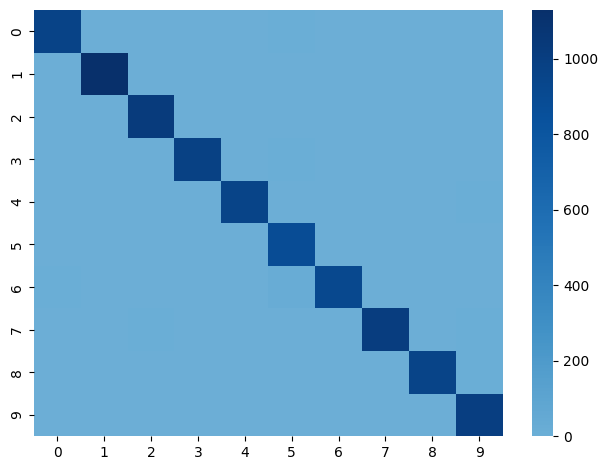

In [74]:
cm = confusion_matrix(true_labels,pred_labels)
print(cm)


sns.heatmap(cm,center=True,cmap='Blues')
plt.tight_layout()

In [70]:
repo = classification_report(true_labels,pred_labels)
print(repo)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.97      0.98      1010
           4       0.99      0.98      0.99       982
           5       0.95      0.99      0.97       892
           6       0.99      0.96      0.98       958
           7       0.99      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.97      0.99      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

